In [1]:
from home_cage_prediction.load.etoh import load_home_cage_data, load_escalation_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [2]:
def drop_agg(df_hc: pd.DataFrame, drop: bool = False):
    AGG_COLS = ["agg_explore", "agg_cons", "agg_low"]
    if drop:
        df_hc = df_hc.drop(columns=AGG_COLS)
    return df_hc

In [3]:
DATA_DIR = Path(os.environ.get("DATA_DIR")) / "raw"

In [4]:
HC_WEEK = "hc-base"
DROP_AGG = False


df_hc = (
    load_home_cage_data(data_dir=DATA_DIR, week=HC_WEEK)
    .pipe(drop_agg, drop=DROP_AGG)
    .set_index("mouse_name")
)
df_cons = load_escalation_data(data_dir=DATA_DIR).set_index("mouse_name")

In [8]:
df = df_hc.join(df_cons)

<Axes: >

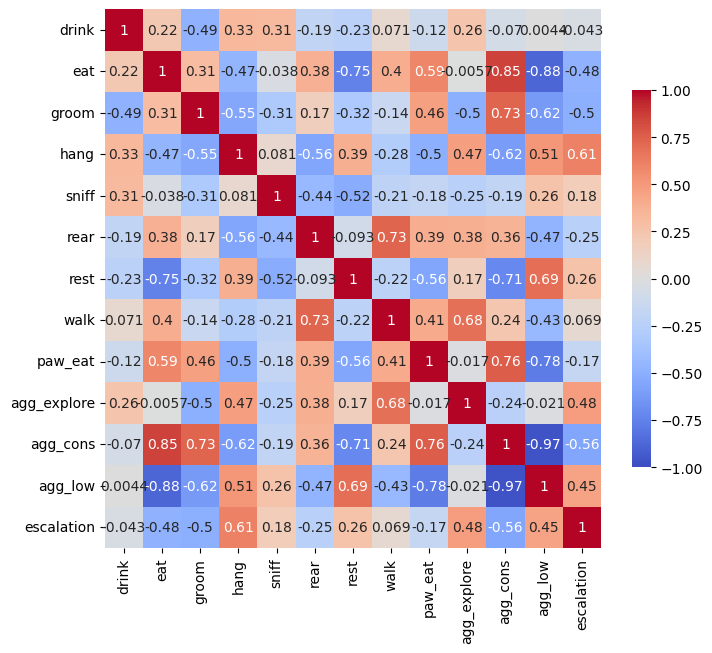

In [10]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(
    df.corr(),
    annot=True,
    cmap="coolwarm",
    center=0,
    ax=ax,
    cbar_kws={"shrink": 0.7},
    vmin=-1,
    vmax=1,
)

Text(0, 0.5, 'log escalation consumption on hc-base')

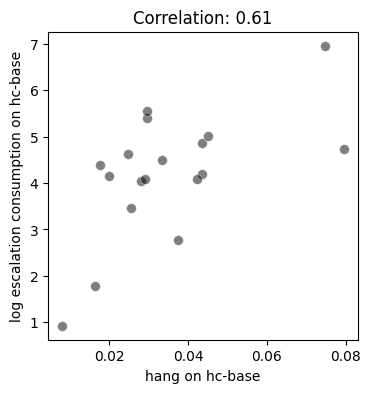

In [14]:
f, ax = plt.subplots(figsize=(4, 4))

hc_feature = "hang"

sns.scatterplot(
    data=df, x=hc_feature, y="escalation", ax=ax, color="black", s=50, alpha=0.5
)

ax.set_title(f"Correlation: {np.corrcoef(df[hc_feature], df['escalation'])[0, 1]:.2f}")
ax.set_xlabel(f"{hc_feature} on {HC_WEEK}")
ax.set_ylabel(f"log escalation consumption on {HC_WEEK}")

R2: -0.15


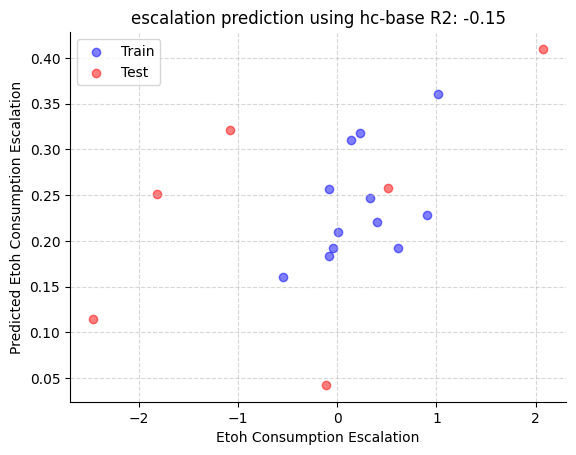

In [87]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale

pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        # ("int", PolynomialFeatures(degree=2)),
        ("reg", Lasso(alpha=0.1)),
    ]
)


X = df.drop(columns=["escalation"])
y = df["escalation"]

# y = np.log(y + 1)
y = scale(y)
# y = y - y.mean()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    # random_state=42,
    shuffle=True,
)

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)
y_true = y_test
score_obs = r2_score(y_true, y_pred)
print(f"R2: {score_obs:.2f}")


plt.scatter(y_train, y_train_pred, color="blue", alpha=0.5, label="Train")
plt.scatter(y_test, y_pred, color="red", alpha=0.5, label="Test")

plt.xlabel("Etoh Consumption Escalation")
plt.ylabel("Predicted Etoh Consumption Escalation")
plt.legend()

plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"escalation prediction using {HC_WEEK} R2: {score_obs:.2f}")

sns.despine(ax=plt.gca())

In [88]:
from sklearn.base import clone

scores = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=True
    )
    pipe_i = clone(pipe)
    pipe_i.fit(X_train, y_train)
    y_pred = pipe_i.predict(X_test)
    y_true = y_test
    score = r2_score(y_true, y_pred)

    scores.append(score)

scores = np.array(scores)
print(f"R2: {scores.mean():.2f}")
np.quantile(scores, [0.025, 0.975])

R2: -1.40


/usr/local/python/current/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e-03, tolerance: 1.189e-03
  model = cd_fast.enet_coordinate_descent(


array([-9.77453439,  0.26232606])